In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, gdown
file_id="1fLKvOc2uohEcdimUemNsL05d4CND5qfq"
zip_path="/content/water_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq
From (redirected): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq&confirm=t&uuid=b9366185-959d-473f-a546-86e50dab4116
To: /content/water_dataset.zip
100%|██████████| 68.7M/68.7M [00:00<00:00, 84.5MB/s]


'/content/water_dataset.zip'

In [3]:
extract_dir="/content/water_dataset"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

In [5]:
import glob
from PIL import Image
import numpy as np
image_dir="/content/water_dataset/data/images"
mask_dir="/content/water_dataset/data/labels"
image_paths=sorted(glob.glob(os.path.join(image_dir, "*tif")))
mask_paths=sorted(glob.glob(os.path.join(mask_dir, "*png")))
valid_pairs=[]
for img_path in image_paths:
  img_name=os.path.basename(img_path).replace(".tif","")
  mask_path=os.path.join(mask_dir, f"{img_name}.png")
  if not os.path.exists(mask_path):
    continue
  if "_" in os.path.basename(mask_path):
    continue
  mask=np.array(Image.open(mask_path))
  if np.max(mask)==0 or np.min(mask)==255:
    continue

  valid_pairs.append((img_path,mask_path))

print(len(valid_pairs), "valid pair")


261 valid pair


In [6]:
def calculate_water_index(img):
  R=img[:, :, 3].astype(np.float32)
  G=img[:, :, 2].astype(np.float32)
  B=img[:, :, 1].astype(np.float32)
  water_index=(G-R)/(G+R+1e-5)
  return np.expand_dims(water_index, axis=-1)

In [7]:
!pip install tifffile

In [8]:
import tifffile as tiff
def load_img_with_index(path):
  img=tiff.imread(path).astype(np.float32)/255.0
  if img.ndim==3 and img.shape[-1]==12:
    water_index=calculate_water_index(img)
    img=np.concatenate([img,water_index],axis=-1)
  return img

In [9]:
images=[]
masks=[]

for img_path, mask_path in valid_pairs:
  img=load_img_with_index(img_path)
  mask=np.array(Image.open(mask_path)).astype(np.uint8)

  if mask.ndim==3:
    mask=mask[:, :, 0]
  mask=np.expand_dims(mask, axis=-1)
  images.append(img)
  masks.append((mask))
images=np.array(images)
masks=np.array(masks)

print("Image Shape: ",images.shape)
print("Mask Shape: ",masks.shape)

Image Shape:  (261, 128, 128, 13)
Mask Shape:  (261, 128, 128, 1)


In [10]:
scaled_images=np.zeros_like(images)
for i in range(images.shape[0]):
  img=images[i]
  min_val=img.min(axis=(0,1), keepdims=True)
  max_val=img.max(axis=(0,1), keepdims=True)
  scaled_images[i]=(img-min_val)/(max_val-min_val+1e-8)
print("After Scaling min: ",scaled_images.min()," | max: ",scaled_images.max())
print("Final image shape: ",scaled_images.shape)
print("Final mask shape: ",masks.shape)

After Scaling min:  0.0  | max:  1.0
Final image shape:  (261, 128, 128, 13)
Final mask shape:  (261, 128, 128, 1)


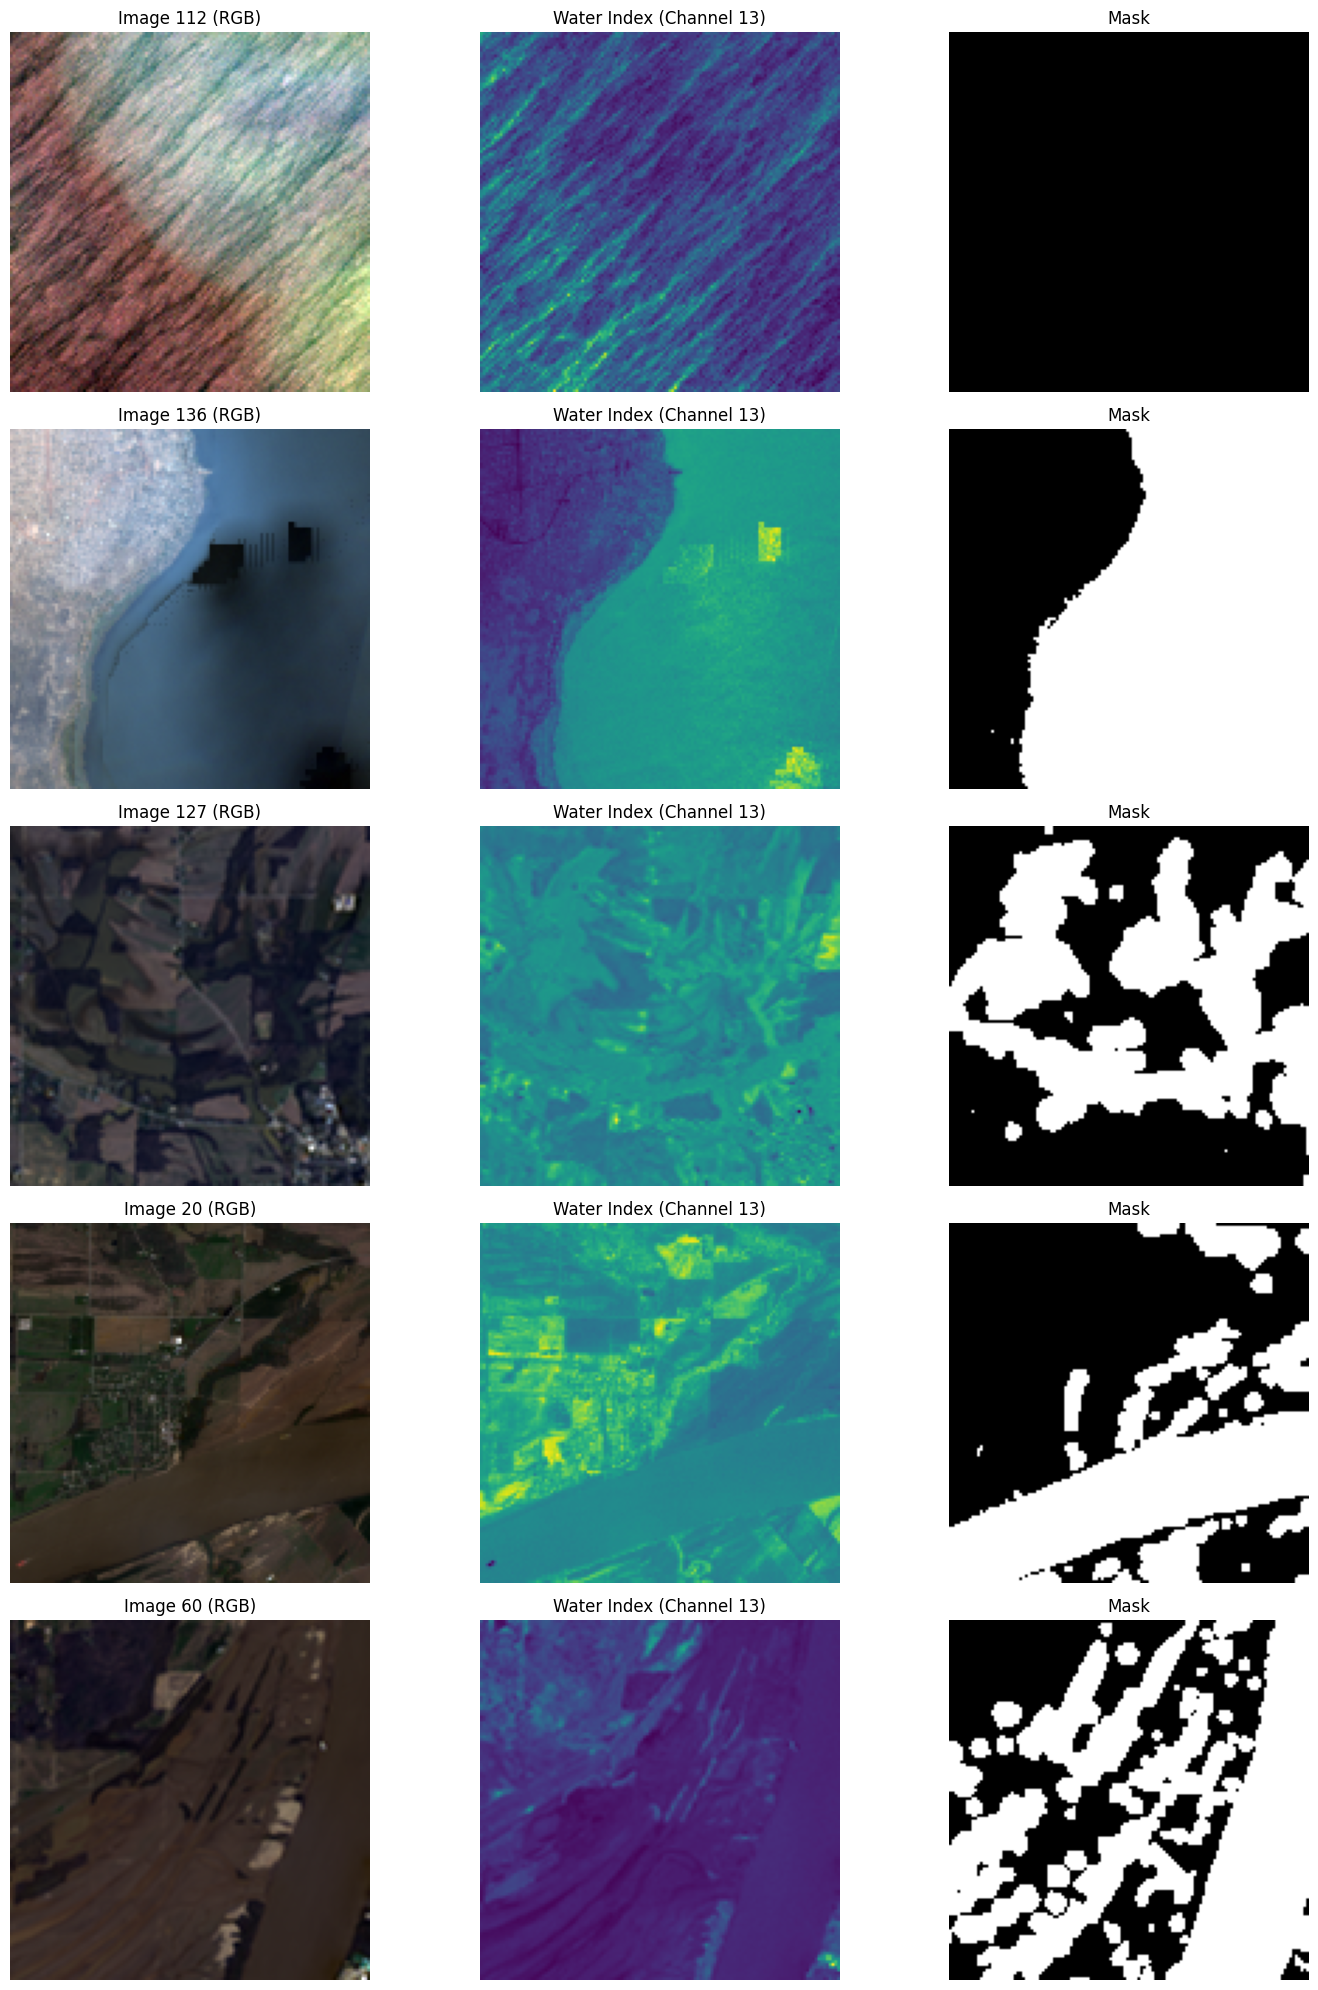

In [14]:
import matplotlib.pyplot as plt
import random
def display_sample_with_water_index(images, masks, num_samples=5, water_index_channel=12):
  plt.figure(figsize=(15, num_samples * 4))
  for i in range(num_samples):
    idx=random.randint(0, len(scaled_images)-1)
    img=scaled_images[idx][:, :, [3,2,1]]
    water_index=scaled_images[idx][:, :, water_index_channel]
    mask=masks[idx][:, :,0]

    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(img)
    plt.title(f"Image {idx+1} (RGB)")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(water_index, cmap='viridis', vmin=0, vmax=1)
    plt.title(f"Water Index (Channel {water_index_channel+1})")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_with_water_index(scaled_images,masks)

In [15]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 17.5 MB/s eta 0:00:00


In [16]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test=train_test_split(scaled_images, masks, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)
print("Train: ",X_train.shape, y_train.shape)
print("Validation: ",X_val.shape, y_val.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (210, 128, 128, 13) (210, 128, 128, 1)
Validation:  (24, 128, 128, 13) (24, 128, 128, 1)
Test:  (27, 128, 128, 13) (27, 128, 128, 1)


In [17]:
import tensorflow as tf
def create_dataset(images, masks, batch_size=16, shuffle=True):
  dataset=tf.data.Dataset.from_tensor_slices((images, masks))
  if shuffle:
    dataset=dataset.shuffle(buffer_size=1000)
  dataset=dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset


In [18]:
train_dataset=create_dataset(X_train, y_train, batch_size=16, shuffle=True)
val_dataset=create_dataset(X_val, y_val, batch_size=16, shuffle=False)
test_dataset=create_dataset(X_test, y_test, batch_size=16, shuffle=False)

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 13)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (3,3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      3,776 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_7[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_8[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_9[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[

 Total params: 1,931,297 (7.37 MB)

 Trainable params: 1,929,889 (7.36 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [32]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + smooth) / (union + smooth)


model.compile(optimizer='adam', loss=iou_loss, metrics=[iou_metric, 'accuracy'])


In [33]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9477 - iou_metric: 0.8349 - loss: 0.2004 - val_accuracy: 0.9003 - val_iou_metric: 0.7217 - val_loss: 0.3012
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9419 - iou_metric: 0.8165 - loss: 0.1891 - val_accuracy: 0.9070 - val_iou_metric: 0.7480 - val_loss: 0.2756
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9532 - iou_metric: 0.8485 - loss: 0.1509 - val_accuracy: 0.9065 - val_iou_metric: 0.7450 - val_loss: 0.2798
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9483 - iou_metric: 0.8378 - loss: 0.1650 - val_accuracy: 0.9029 - val_iou_metric: 0.7327 - val_loss: 0.2974
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9498 - iou_metric: 0.8331 - loss: 0.1639 - val_accuracy: 0.9092 - val_iou_metric: 0.7581 - val_loss: 0.2714
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9520 - iou_metric: 0.8465 - loss: 0.1562 - val_accuracy: 0.9229 

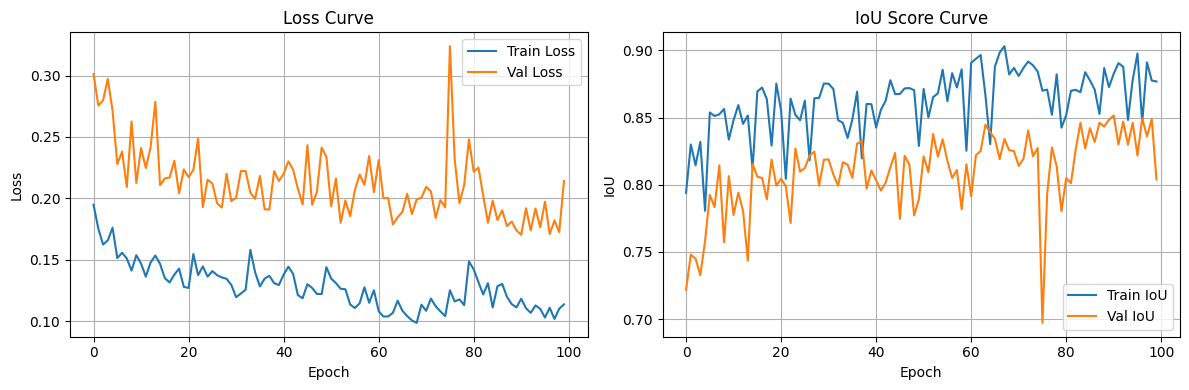

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Score Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


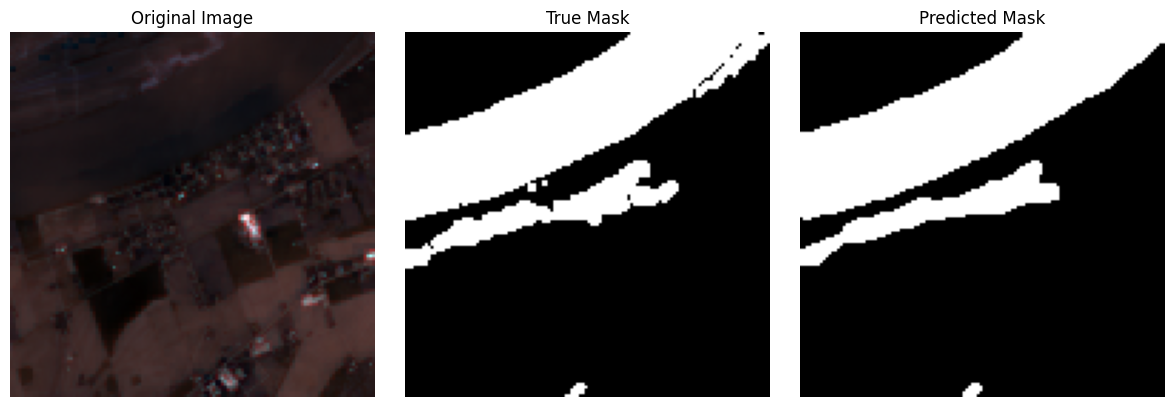

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


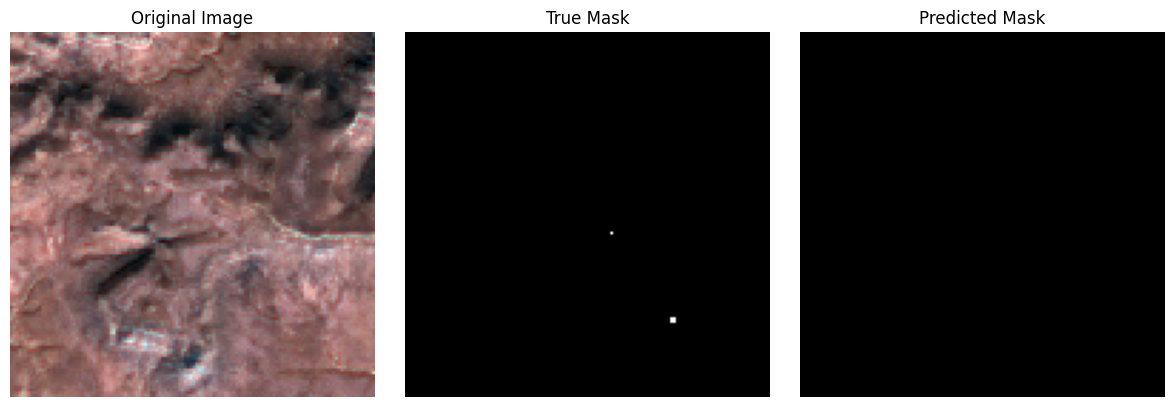

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


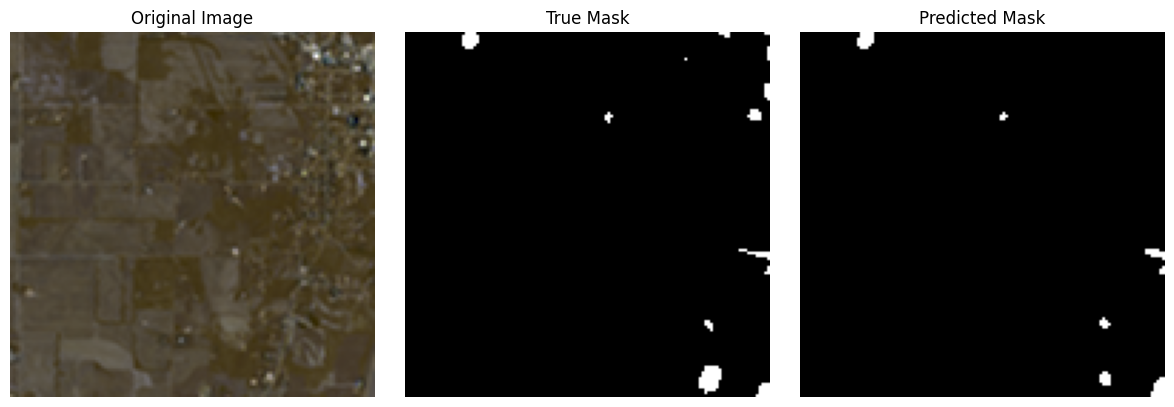

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


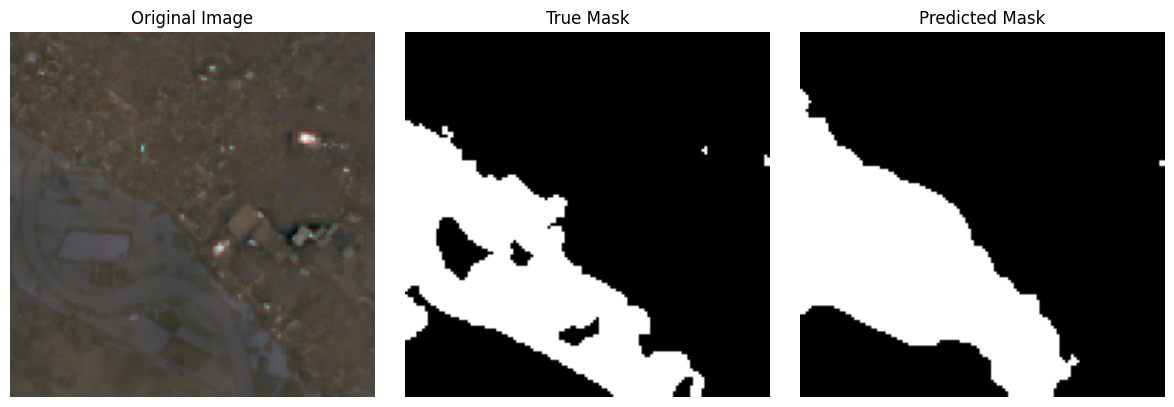

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


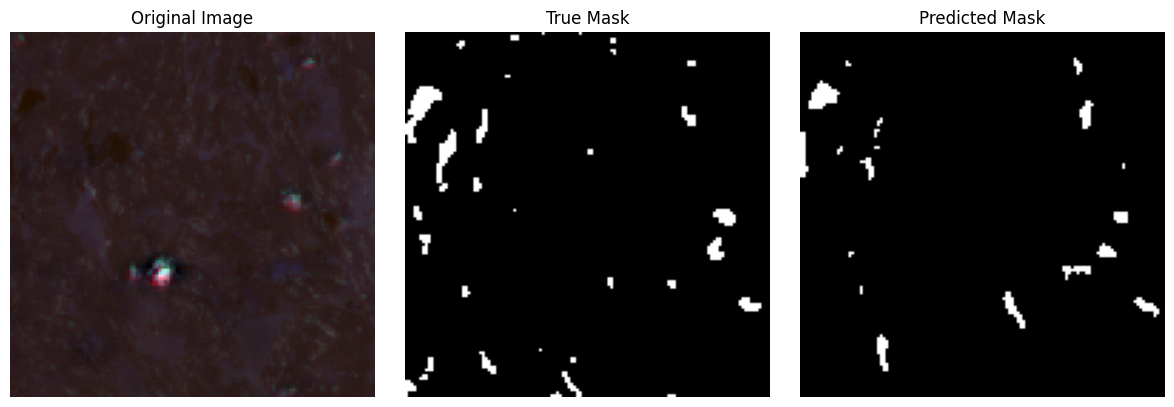

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


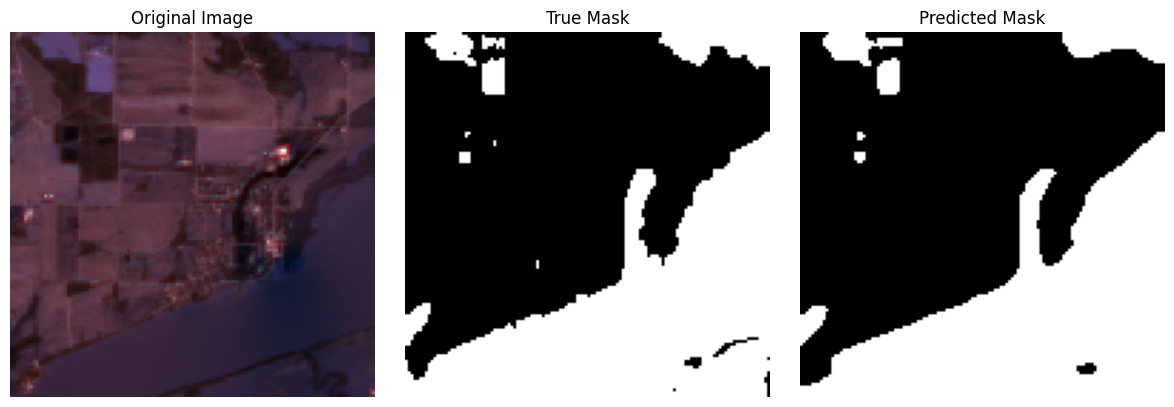

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


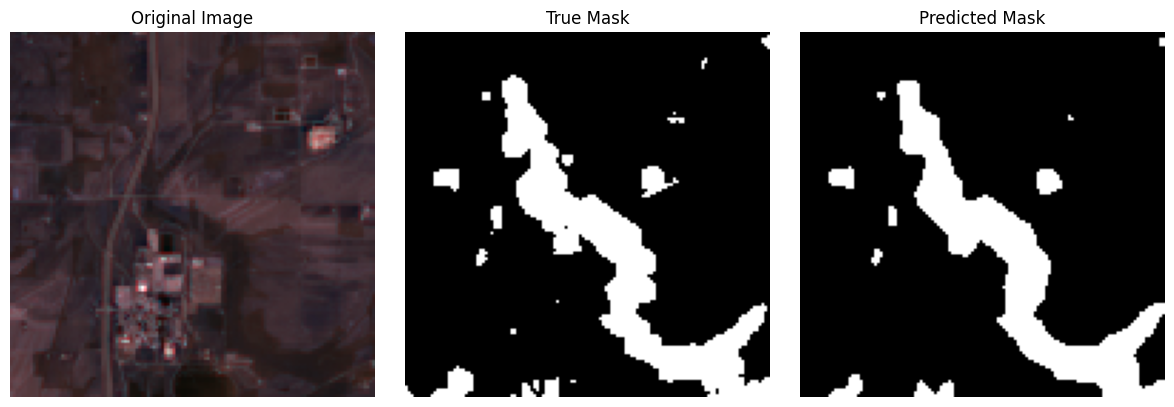

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


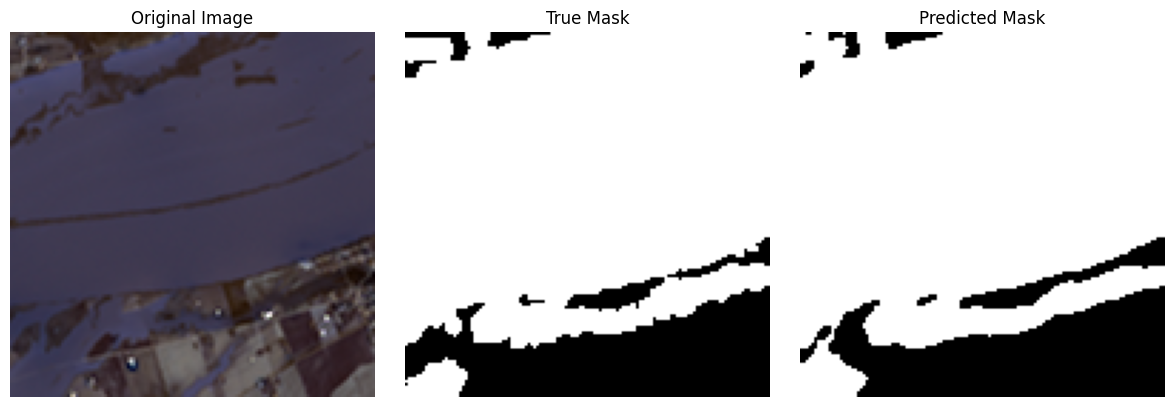

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


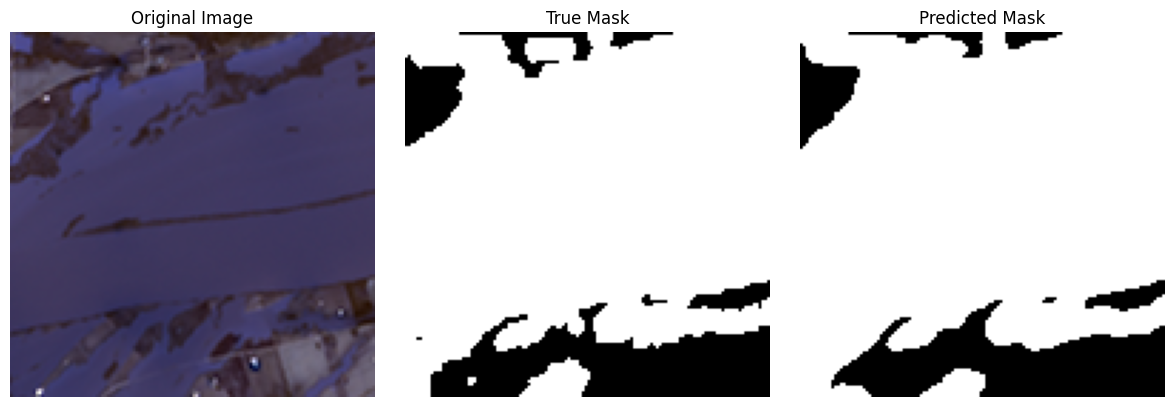

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


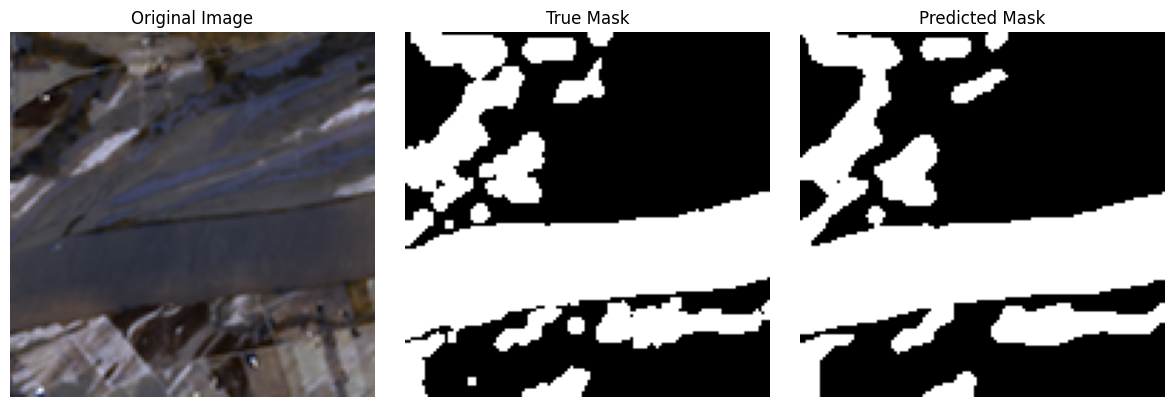

In [38]:
import matplotlib.pyplot as plt

def visualize_predictions(model, X, y_true, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = y_true[idx]

        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image[..., :3])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

visualize_predictions(model, X_test, y_test, num_samples=10)


In [40]:
model.save("U-Net_Multispectral_WaterSegmentation.h5")
print("Model saved as 'U-Net_Multispectral_WaterSegmentation.h5'")


Model saved as 'U-Net_Multispectral_WaterSegmentation.h5'
